<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Donut/RVL-CDIP/Fine_tune_Donut_on_toy_RVL_CDIP_(document_image_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, let's install the relevant libraries: 🤗 Transformers & Datasets, and Sentencepiece (the latter is used for tokenization).

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q datasets sentencepiece

## Load dataset

Next, let's load a dataset from the hub. I've prepared a toy dataset which is a small subset of [RVL-CDIP](https://paperswithcode.com/dataset/rvl-cdip), consisting of (image, text) pairs. The text is what the model should learn to generate given the visual input.

Here, it's important to understand how targets should be prepared for Donut: you need to create a string called "ground_truth" (or "ground_truths", in case there are multiple possible ground truth target sequences, see DocVQA). This is a string format of a dictionary (JSON dumped), containing either a `gt_parse` or `gt_parses` key. 

For document image classification, the `gt_parse` follows the format of `{"class" : {class_name}}`, for example, `{"class" : "scientific_report"}` or `{"class" : "presentation"}`.

The notebook for creating a 🤗 Dataset (custom data) for Donut can be found in my Github repo [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/RVL-CDIP/Preparing_an_image_classification_dataset_for_Donut.ipynb).

Let's load the dataset first:



In [1]:
from datasets import load_dataset

dataset = load_dataset("ZaNioxX/DocILE_10_5_ImageClassification_donut_test20")

In [2]:
id2label = {id: label for id, label in enumerate(dataset['train'].features['label'].names)}
print(id2label)

{0: 'credit_note', 1: 'debit_note', 2: 'order', 3: 'proforma', 4: 'purchase_order', 5: 'receipt', 6: 'sales_order', 7: 'tax_invoice', 8: 'utility_bill'}


Let's check out an example:

In [3]:
example = dataset['train'][0]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1692x2245>,
 'label': 0,
 'ground_truth': '{"gt_parse": {"class" : "credit_note"}}'}

As can be seen, we prepared the "ground_truth" key, which is a string-formatted dictionary containing a single `gt_parse` key.

In [4]:
example = dataset["train"][0]
example["ground_truth"]

'{"gt_parse": {"class" : "credit_note"}}'

One can use Python's `ast.literal_eval` function to turn the string into a Python dictionary. This helps verifying we have created the gt_parse string in the correct way:

In [5]:
from ast import literal_eval

literal_eval(example["ground_truth"])['gt_parse']

{'class': 'credit_note'}

## Load model and processor

Next, we'll load the model itself (Donut is an instance of the [VisionEncoderDecoderModel](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder) class), as well as its processor (`DonutProcessor`), which can be used to prepare data for the model.

We'll update some things; namely the max sequence length of the decoder, as well as the size of the images. Note that this impacts the amount of memory used when fine-tuning the model.

Note that the exact hyperparameters can be found here: https://github.com/clovaai/donut/blob/master/config/train_rvlcdip.yaml.

In [6]:
from transformers import VisionEncoderDecoderConfig

max_length = 8
# image_size = [2560, 1920]
# let's use a smaller image size (height, width) because otherwise OOM
# the higher the resolution, the better the results will be
# so if you have a big GPU, feel free to increase
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [7]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

2023-09-05 00:38:44.248611: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 00:38:44.283288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 00:38:44.938909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [8]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/models/donut/processing_donut.py:189: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## Prepare dataset

The first thing we'll do is add the class names as added tokens to the vocabulary of the decoder of Donut, and the corresponding tokenizer.

This will result in a slight increase in performance, as otherwise a class might be split up into multiple subword tokens (e.g. the class "advertisement" might be split up into "adv", "ertisement"). It is beneficial to let the model just learn a single embedding vector for the token "advertisement".

In [9]:
len(processor.tokenizer)

57525

In [10]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [11]:
additional_tokens = ["<credit_note/>", "<debit_note/>", "<order/>", "<proforma/>", "<purchase_order/>", 
                     "<receipt/>", "<sales_order/>", "<tax_invoice/>", "<utility_bill/>"]


add_tokens(additional_tokens)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57534. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [ ]:
additional_tokens = ["<advertisement/>", "<budget/>", "<email/>", "<file_folder/>", "<form/>", "<handwritten/>", "<invoice/>",
  "<letter/>", "<memo/>", "<news_article/>", "<presentation/>", "<questionnaire/>", "<resume/>",
  "<scientific_publication/>", "<scientific_report/>", "<specification/>"]

add_tokens(additional_tokens)

In [12]:
processor.tokenizer.convert_tokens_to_ids(["<file_folder/>"])

[3]

In [13]:
len(processor.tokenizer)

57534

Next, we create a regular PyTorch Dataset. The class below returns `(pixel_values, labels)` pairs for each item of the dataset.

It's all we need for training the model!

In [14]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # pixel values (we remove the batch dimension)
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        
        encoding = dict(pixel_values=pixel_values,
                        labels=labels)
        
        return encoding

Let's create the dataset:

In [15]:
train_dataset = DonutDataset("ZaNioxX/DocILE_10_5_ImageClassification_donut_test20", max_length=max_length,
                             split="train", task_start_token="<s_docile>", prompt_end_token="<s_docile>",
                             sort_json_key=False, # rvlcdip dataset is preprocessed, so no need for this
                             )

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57536. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 57537. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Let's check the first item of this dataset:

In [16]:
train_dataset[0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([57534, 57525, 57535,     2,  -100,  -100,  -100

## Create PyTorch DataLoader

Now that we've created a PyTorch dataset, we can create a corresponding DataLoader:



In [17]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True)

Let's check out the first batch:

In [18]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['pixel_values', 'labels'])


Let's check the labels:

In [19]:
for id in batch['labels'][0].tolist():
    if id != -100:
        print(processor.decode([id]))
    else:
        print(id)

<s_class>
<sales_order/>
</s_class>
</s>
-100
-100
-100
-100


Let's visualize the pixel values by denormalizing:

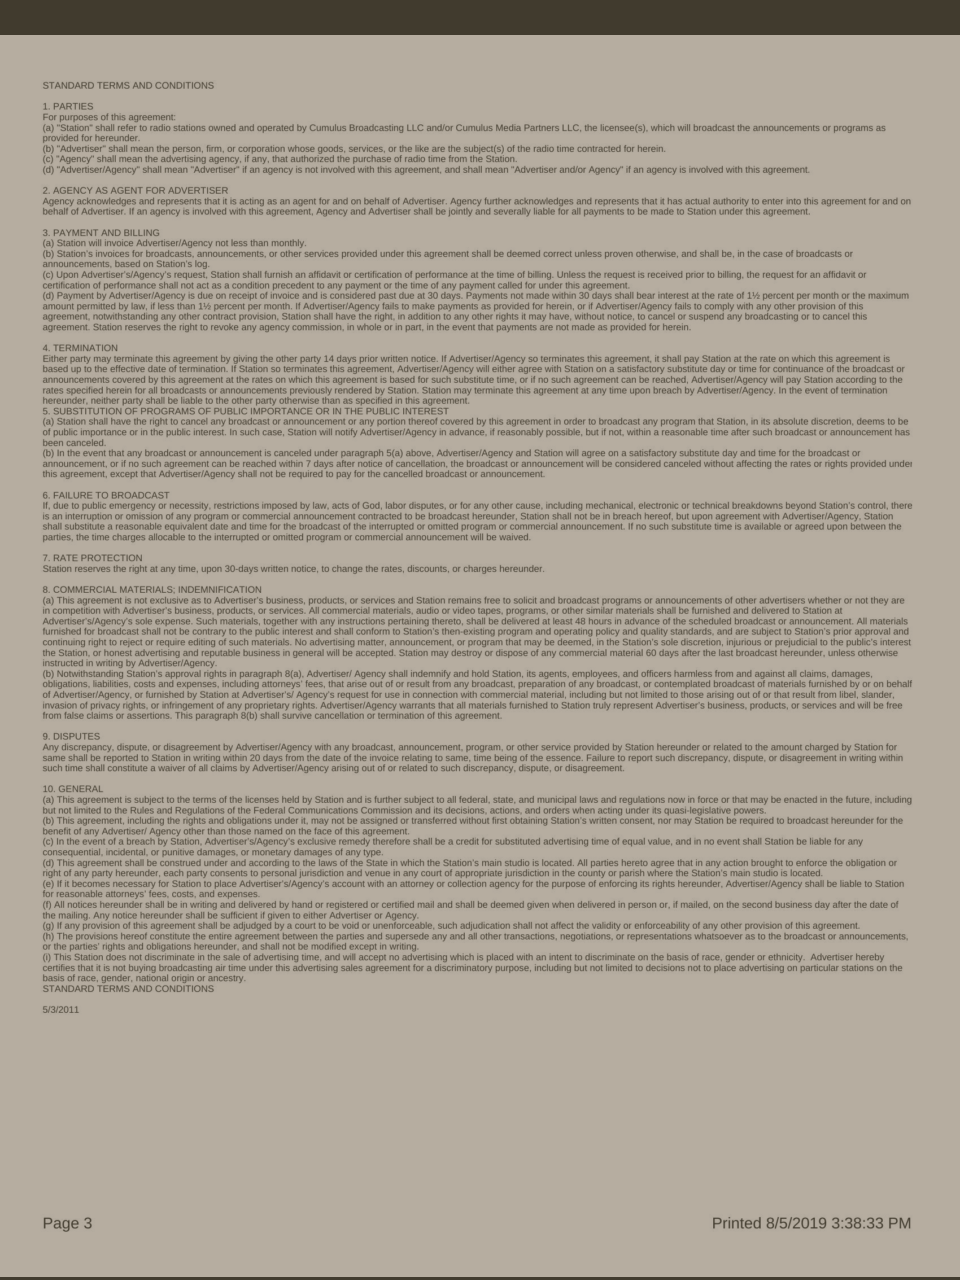

In [20]:
from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

This indeed looks like an email. So data preparation seems ok!

## Train model

Ok there's one additional thing before we can start training the model: during training, the model can create the `decoder_input_ids` (the decoder inputs) automatically based on the `labels` (by simply shifting them one position to the right, prepending the `decoder_start_token_id` and replacing labels which are -100 by the `pad_token_id`). Therefore, we need to set those variables, to make sure the `decoder_input_ids` are created automatically.

This ensures we only need to prepare labels for the model. Theoretically you can also create the `decoder_input_ids` yourself and not set the 2 variables below. This is what the original authors of Donut did.

In [21]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_docile>'])[0]

In [22]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_docile>


Let's train!

In [23]:
import torch
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

for epoch in range(4):
    print("Epoch:", epoch+1)  
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        #print(pixel_values)
        #print(labels)
        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print("Loss:", loss.item())
    #if (epoch+1) % 2 == 0:
        #model.push_to_hub("ZaNioxX/DocILE_10_5_ImageClassification_donut_" + str(epoch+1), private=True)

Epoch: 1


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 19.86787223815918
Epoch: 2


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 4.7910075187683105
Epoch: 3


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.5684309005737305
Epoch: 4


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.6872987747192383


## Evaluate

Finally, we compute the accuracy on the test set.

Note that this will be far from perfect as we were just training on a toy dataset. The entire dataset consists of 400,000 images.

We'll verify whether the model is better than random (which means 1/number of classes = 1/16 = 0.0625) accuracy.

We'll use the token2json method of the processor to turn the generated sequences into JSON.

In [72]:
import re

model.eval()

dataset = load_dataset("ZaNioxX/DocILE_10_5_ImageClassification_donut_test20", split="test")

output_list = []
real = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_docile>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)
    real.append(gt["class"])
    output_list.append(seq["class"])

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

  0%|          | 0/33 [00:00<?, ?it/s]

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


{'accuracies': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'mean_accuracy': 0.5151515151515151} length : 33


In [26]:
scores["mean_accuracy"]

0.5151515151515151

In [73]:
print(real)

['credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'debit_note', 'debit_note', 'order', 'order', 'proforma', 'proforma', 'purchase_order', 'purchase_order', 'receipt', 'receipt', 'sales_order', 'sales_order', 'tax_invoice', 'tax_invoice', 'utility_bill', 'utility_bill']


In [74]:
print(output_list)

['credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'debit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note']


In [75]:
output_list[20] = "order"

In [76]:
output_list[20]

'order'

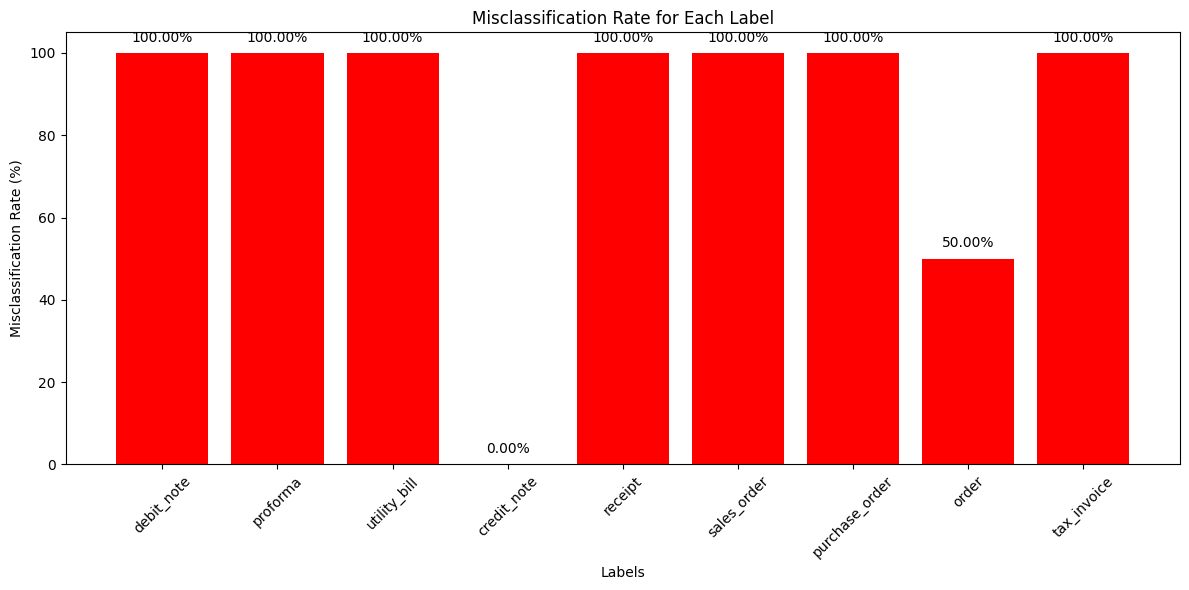

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom order for labels
custom_order = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

# Create a dictionary to store the counts of each label
label_counts = {label: real.count(label) for label in set(real)}

# Initialize a dictionary to store the count of correct predictions for each label
correct_counts = {label: 0 for label in set(real)}

# Count the correct predictions for each label
for r, o in zip(real, output_list):
    if r == o:
        correct_counts[r] += 1

# Calculate the misclassification rate (percentage of wrong classifications) for each label
misclassification_per_label = {label: (1 - (correct_counts[label] / label_counts[label])) * 100 if label_counts[label] > 0 else 0 for label in custom_order}

# Create a list of labels and corresponding misclassification percentages
labels = [label for label in custom_order]
misclassification_values = [misclassification_per_label[label] for label in custom_order]

# Create a bar plot with custom ordering
plt.figure(figsize=(12, 6))
plt.bar(labels, misclassification_values, color='red')
plt.xlabel('Labels')
plt.ylabel('Misclassification Rate (%)')
plt.title('Misclassification Rate for Each Label')
plt.xticks(rotation=45)

# Display the misclassification percentage above each bar, with adjusted vertical alignment
for i, misclassification in enumerate(misclassification_values):
    plt.text(i, misclassification + 2, f'{misclassification:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


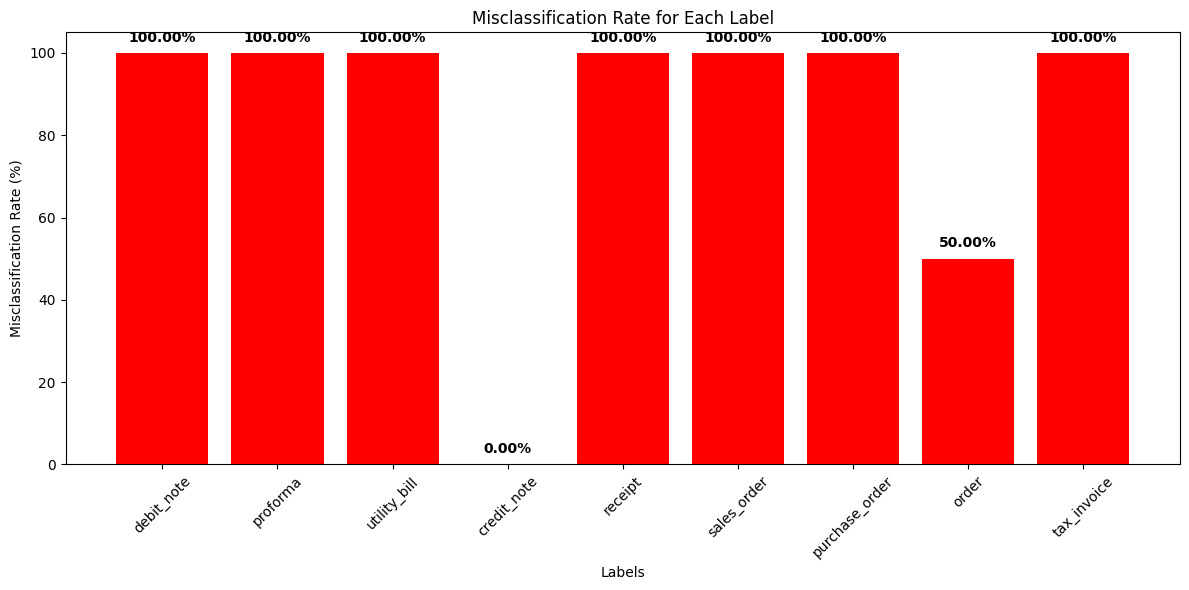

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom order for labels
custom_order = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

# Create a dictionary to store the counts of each label
label_counts = {label: real.count(label) for label in set(real)}

# Initialize a dictionary to store the count of correct predictions for each label
correct_counts = {label: 0 for label in set(real)}

# Count the correct predictions for each label
for r, o in zip(real, output_list):
    if r == o:
        correct_counts[r] += 1

# Calculate the misclassification rate (percentage of wrong classifications) for each label
misclassification_per_label = {label: (1 - (correct_counts[label] / label_counts[label])) * 100 if label_counts[label] > 0 else 0 for label in custom_order}

# Create a list of labels and corresponding misclassification percentages
labels = [label for label in custom_order]
misclassification_values = [misclassification_per_label[label] for label in custom_order]

# Create a bar plot with custom ordering
plt.figure(figsize=(12, 6))
plt.bar(labels, misclassification_values, color='red')
plt.xlabel('Labels')
plt.ylabel('Misclassification Rate (%)')
plt.title('Misclassification Rate for Each Label')
plt.xticks(rotation=45)

# Display the misclassification percentage above each bar, with adjusted vertical alignment
for i, misclassification in enumerate(misclassification_values):
    plt.text(i, misclassification + 2, f'{misclassification:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


In [64]:
print(output_list)

['credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'order', 'credit_note', 'credit_note', 'credit_note', 'debit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note', 'credit_note']


That looks a lot better than random accuracy, suggesting that our model seems to learn well!

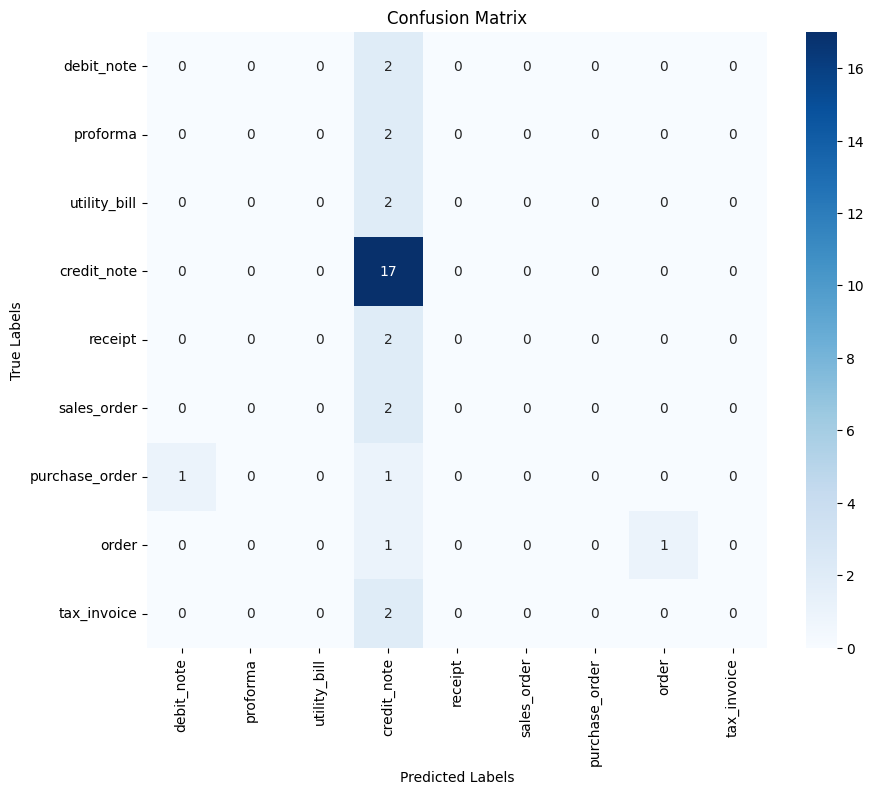

In [96]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the label mapping
label_mapping = {'debit_note': 0, 'proforma': 1, 'utility_bill': 2, 'credit_note': 3, 'receipt': 4, 'sales_order': 5, 'purchase_order': 6, 'order': 7, 'tax_invoice': 8}

# Map labels to integers
real = [label_mapping[label] for label in real]
output = [label_mapping[label] for label in output_list]

# Create the confusion matrix
conf_matrix = confusion_matrix(real, output)

# Create a DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=list(label_mapping.keys()), columns=list(label_mapping.keys()))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


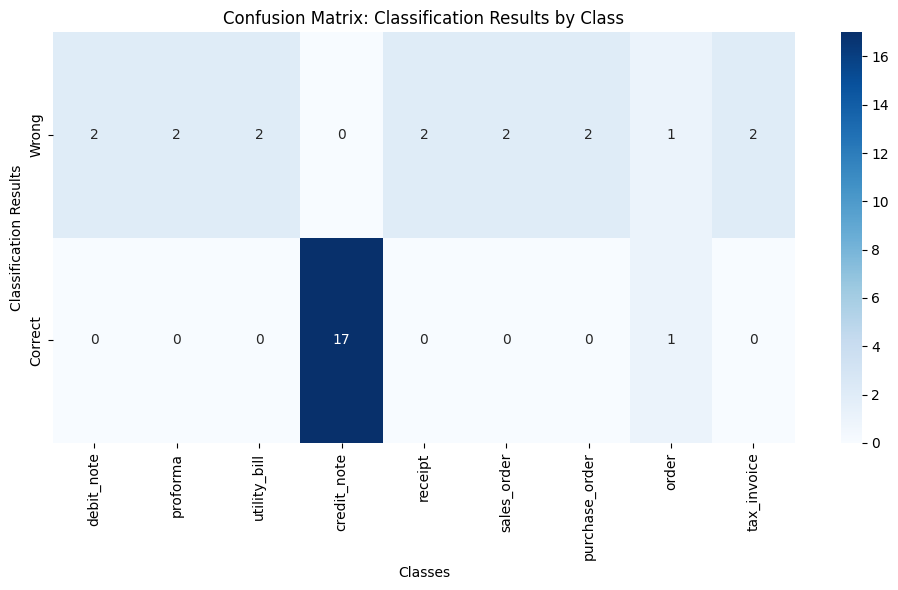

In [88]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define categories and data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

# Calculate the confusion matrix
conf_matrix = np.zeros((2, len(categories)))  # Initialize a matrix for wrong (0) and correct (1) classifications

for i, category in enumerate(categories):
    for r, o in zip(real, output_list):
        if r == category and o == category:
            conf_matrix[1, i] += 1  # Correct classification
        elif r == category and o != category:
            conf_matrix[0, i] += 1  # Wrong classification

# Create a confusion matrix heatmap using Seaborn with switched axes
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=['Wrong', 'Correct'])
plt.xlabel('Classes')
plt.ylabel('Classification Results')
plt.title('Confusion Matrix: Classification Results by Class')
plt.tight_layout()
plt.show()


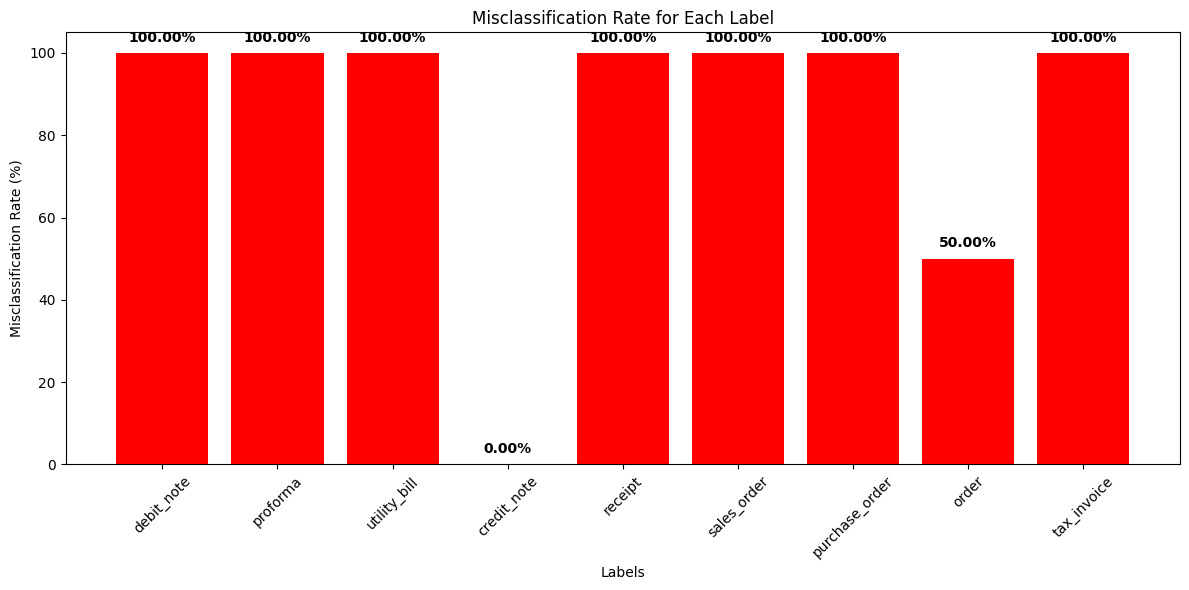

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Define the custom order for labels
custom_order = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

# Create a dictionary to store the counts of each label
label_counts = {label: real.count(label) for label in set(real)}

# Initialize a dictionary to store the count of correct predictions for each label
correct_counts = {label: 0 for label in set(real)}

# Count the correct predictions for each label
for r, o in zip(real, output_list):
    if r == o:
        correct_counts[r] += 1

# Calculate the misclassification rate (percentage of wrong classifications) for each label
misclassification_per_label = {label: (1 - (correct_counts[label] / label_counts[label])) * 100 if label_counts[label] > 0 else 0 for label in custom_order}

# Create a list of labels and corresponding misclassification percentages
labels = [label for label in custom_order]
misclassification_values = [misclassification_per_label[label] for label in custom_order]

# Create a bar plot with custom ordering
plt.figure(figsize=(12, 6))
plt.bar(labels, misclassification_values, color='red')
plt.xlabel('Labels')
plt.ylabel('Misclassification Rate (%)')
plt.title('Misclassification Rate for Each Label')
plt.xticks(rotation=45)

# Display the misclassification percentage above each bar, with adjusted vertical alignment
for i, misclassification in enumerate(misclassification_values):
    plt.text(i, misclassification + 2, f'{misclassification:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
